In [1]:
## import the necessary libraries for time series modelling
!pip install pmdarima
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES
from statsmodels.tsa.statespace.tools import diff

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('Singapore Electricity Generation.csv')
df = df.drop(columns=['Data Series'])
df = df.T
df.index.name = 'Date'
df.columns = ['Electricity Generation']
df.index = pd.to_datetime(df.index)
df = df.sort_index(ascending=True)
df.to_csv('Electricity Generation In SG.csv')
df

,Electricity Generation
Date,
1975-01-01,341.8
1975-02-01,289.6
1975-03-01,342.8
1975-04-01,348.6
1975-05-01,351.4
...,...
2022-01-01,4780.2
2022-02-01,4287.3
2022-03-01,4886.1


In [12]:
df.sort_values(by=['Electricity Generation'])

,Electricity Generation
Date,
1975-02-01,289.6
1976-02-01,332.3
1975-01-01,341.8
1975-03-01,342.8
1975-06-01,343.3
...,...
2021-07-01,4801.6
2021-05-01,4808.0
2021-10-01,4825.3


In [74]:
mask1 = (df.index >= '1975-05-01') & (df.index <= '1976-05-01')
mask2 = (df.index >= '1985-05-01') & (df.index <= '1986-05-01')
mask3 = (df.index >= '1995-05-01') & (df.index <= '1996-05-01')
mask4 = (df.index >= '2005-05-01') & (df.index <= '2006-05-01')
mask5 = (df.index >= '2015-05-01') & (df.index <= '2016-05-01')
mask6 = (df.index >= '2021-05-01') & (df.index <= '2022-05-01')

year75 = df.loc[mask1]
year85 = df.loc[mask2]
year95 = df.loc[mask3]
year05 = df.loc[mask4]
year15 = df.loc[mask5]
year22 = df.loc[mask6]

yearArr = [year75, year85, year95, year05, year15, year22]
for i in range(len(yearArr)):
    yearArr[i] = yearArr[i].reset_index()
    yearArr[i] = yearArr[i].drop(columns='Date')

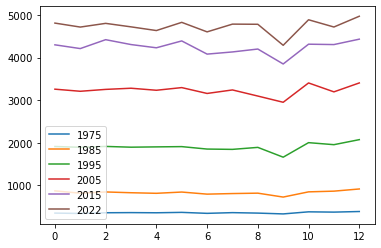

In [85]:
plt.plot(yearArr[0], label='1975')
plt.plot(yearArr[1], label='1985')
plt.plot(yearArr[2], label='1995')
plt.plot(yearArr[3], label='2005')
plt.plot(yearArr[4], label='2015')
plt.plot(yearArr[5], label='2022')
plt.legend(loc='lower left')

In [ ]:
sumArr = []
for i in range(len(yearArr)):
    yearArr[i] = yearArr[i].reset_index()
    yearArr[i] = yearArr[i].drop(columns='Date')
    sumArr.append(yearArr[i].sum())
    
sumArr = np.array(sumArr)
sumArr = sumArr.reshape(6,)

Text(0, 0.5, 'Electricity Generation (GwH)')

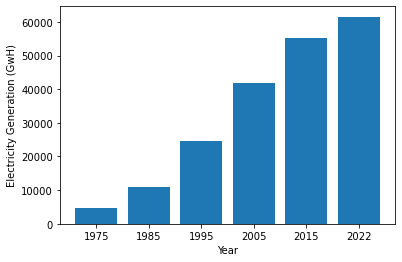

In [70]:
names = ['1975', '1985', '1995', '2005', '2015', '2022']
plt.bar(names, sumArr)
plt.xlabel('Year')
plt.ylabel('Electricity Generation (GwH)')

### Data Exploration

<AxesSubplot:xlabel='Date'>

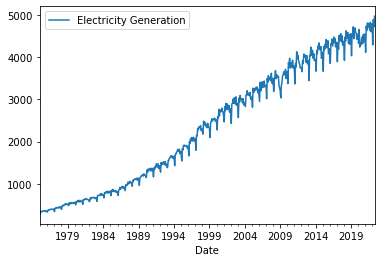

In [3]:
df.plot()

In [4]:
## checking for any null values
print(df.isnull().sum())

Electricity Generation    0
dtype: int64


<AxesSubplot:ylabel='Frequency'>

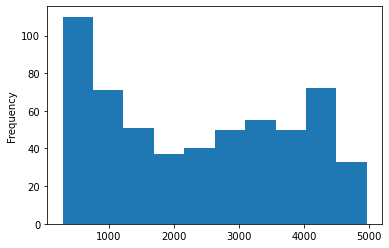

In [5]:
df['Electricity Generation'].plot(kind='hist')

<AxesSubplot:xlabel='Electricity Generation'>

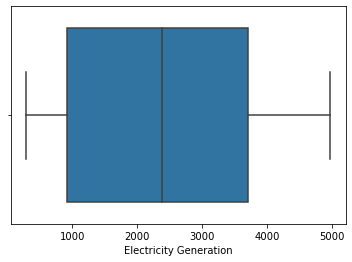

In [6]:
sns.boxplot(df['Electricity Generation'])

### Decomposition Plot

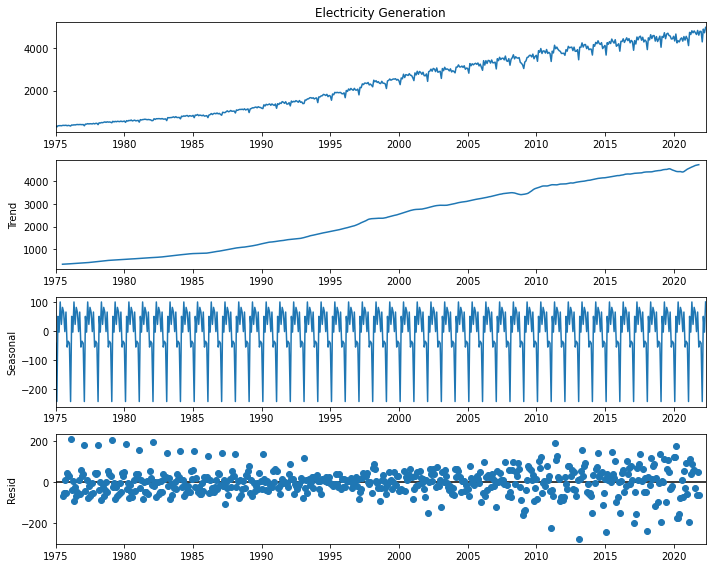

In [7]:
result = seasonal_decompose(df['Electricity Generation'], model='additive')
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

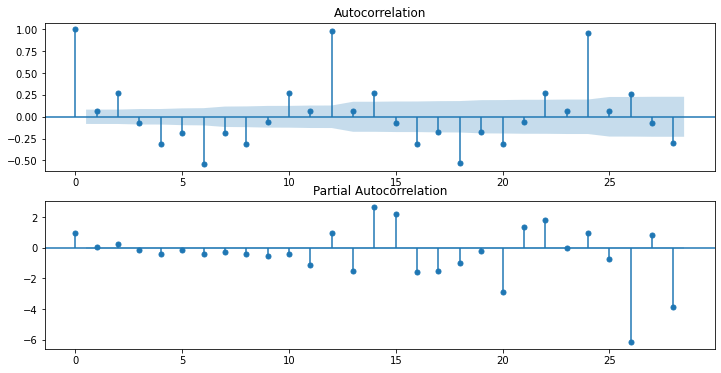

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

In [9]:
df

,Electricity Generation
Date,
1975-01-01,341.8
1975-02-01,289.6
1975-03-01,342.8
1975-04-01,348.6
1975-05-01,351.4
...,...
2022-01-01,4780.2
2022-02-01,4287.3
2022-03-01,4886.1


### Stationarity

In [10]:
## checking for stationarity
test1 = df[df.index<='1998-08']
test2 = df[df.index>'1998-08']
test1Mean = test1['Electricity Generation'].mean()
test2Mean = test2['Electricity Generation'].mean()
test1Var = test1['Electricity Generation'].var()
test2Var = test2['Electricity Generation'].var()
print(f'Group 1 Mean: {test1Mean} | Group 2 Mean: {test2Mean}')
print(f'Group 1 Var: {test1Var} | Group 2 Var: {test2Var}')

Group 1 Mean: 1080.444366197183 | Group 2 Mean: 3655.986315789474
Group 1 Var: 337523.61427910224 | Group 2 Var: 477835.21470644913


In [11]:
## conduct augmented dicky fuller test
pval = adfuller(df['Electricity Generation'])
print('p-val of time series: %f' % pval[1])

p-val of time series: 0.990521


In [12]:
df = df.diff()
df = df.dropna()
df

,Electricity Generation
Date,
1975-02-01,-52.2
1975-03-01,53.2
1975-04-01,5.8
1975-05-01,2.8
1975-06-01,-8.1
...,...
2022-01-01,-3.7
2022-02-01,-492.9
2022-03-01,598.8


In [13]:
## conduct augmented dicky fuller test
pval = adfuller(df['Electricity Generation'])
print('p-val of time series: %f' % pval[1])

p-val of time series: 0.000000


### ACF and PACF Plots

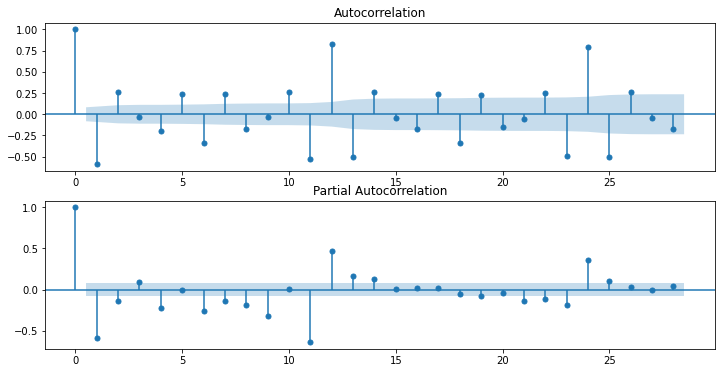

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(df['Electricity Generation'], ax=ax[0])
plot_pacf(df['Electricity Generation'], ax=ax[1])
plt.show()

### Simple Moving Average Model

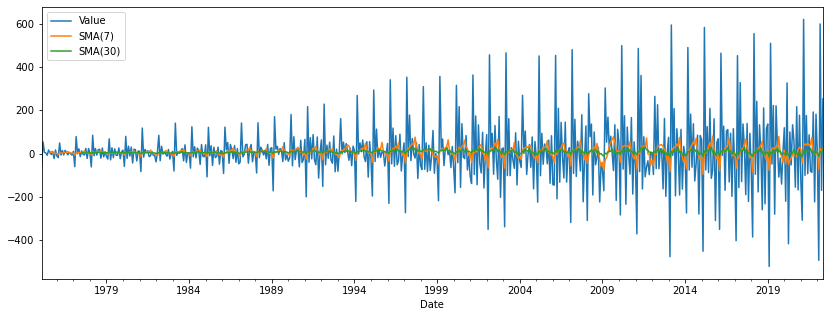

In [15]:
## Simple Moving Average Model
df_SMA = df['Electricity Generation']
ax = df_SMA.plot(figsize=(14, 5))
df_SMA.rolling(window=7).mean().plot(ax=ax)
df_SMA.rolling(window=30).mean().plot(ax=ax)
ax.legend(labels=['Value', 'SMA(7)', 'SMA(30)'])
plt.show()

In [87]:
df

,Electricity Generation
Date,
1975-01-01,341.8
1975-02-01,289.6
1975-03-01,342.8
1975-04-01,348.6
1975-05-01,351.4
...,...
2022-01-01,4780.2
2022-02-01,4287.3
2022-03-01,4886.1


### HWES

In [93]:
train_data

,Electricity Generation
Date,
1975-01-01,341.8
1975-02-01,289.6
1975-03-01,342.8
1975-04-01,348.6
1975-05-01,351.4
...,...
1998-05-01,2462.3
1998-06-01,2379.1
1998-07-01,2417.8


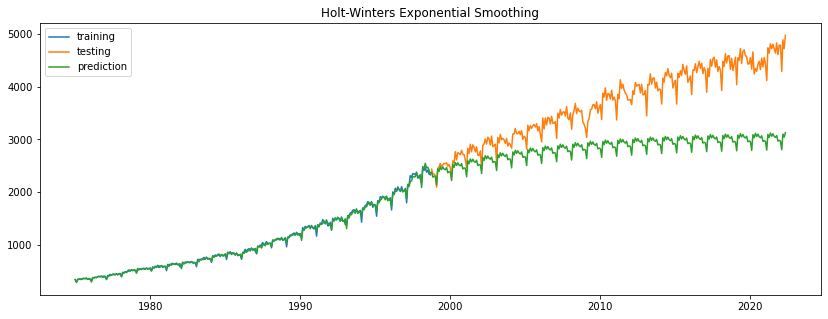

,MAE,MAPE,MSE,RMSE,AIC
0,21.701313,0.020979,945.443933,30.748072,1986.721558


In [124]:
es_model = HWES(train_data, seasonal_periods=12, trend='add', seasonal='add',
damped_trend=True).fit()
pred1 = es_model.predict(start='1975-01-01', end='2022-05-01')
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data, label='training')
ax.plot(test_data, label='testing')
ax.plot(pred1, label='prediction')
plt.legend()
plt.title('Holt-Winters Exponential Smoothing')
plt.show()

train_mae = mean_absolute_error(train_data, pred1[pred1.index<'1998-10'])
train_mape = mean_absolute_percentage_error(train_data, pred1[pred1.index<'1998-10'])
train_mse = mean_squared_error(train_data, pred1[pred1.index<'1998-10'])
train_rmse = np.sqrt(train_mse)
aic = es_model.aic

# test_mae = mean_absolute_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_mape = mean_absolute_percentage_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_mse = mean_squared_error(test_data, pred1[pred1.index>='2016-08-21'])
# test_rmse = np.sqrt(test_mse)

metrics = []
metrics.append(train_mae)
metrics.append(train_mape)
metrics.append(train_mse)
metrics.append(train_rmse)
metrics.append(aic)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,5))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE', 'AIC'])
metrics_df

In [95]:
# exogCO = CO[['T','RH']]

## fit the data into the SARIMAX model
arima_model = SARIMAX(df['Electricity Generation'], order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 12)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:             Electricity Generation   No. Observations:                  569
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3036.533
Date:                            Mon, 08 Aug 2022   AIC                           6083.067
Time:                                    00:37:55   BIC                           6104.671
Sample:                                01-01-1975   HQIC                          6091.505
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1782      0.057      3.146      0.002       0.067       0.289
ma.L1         -0.6509      0.049    -13.397      0.000      -0.746      -0.556
ar.S.L12      -0.1492      0.045     -3.298      0.001      -0.238      -0.061
ma.S.L12      -0.7038      0.033    -21.528      0.000      -0.768      -0.640
sigma2      3180.7571    129.431     24.575      0.000    2927.077    3434.437
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               582.24
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):              13.62   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

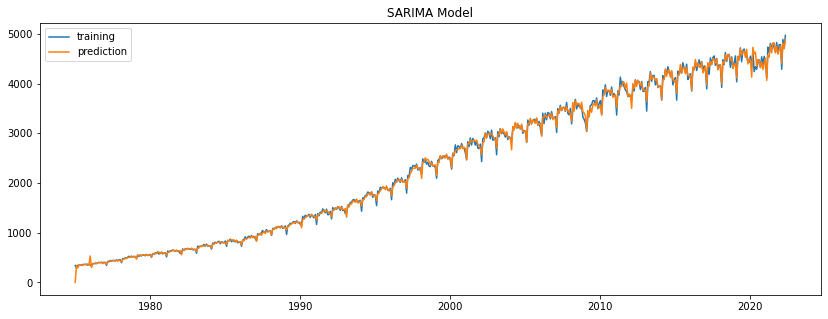

In [98]:
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df['Electricity Generation'], label='training')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMA Model')
plt.show()

In [105]:
mae = mean_absolute_error(df['Electricity Generation'], pred)
mape = mean_absolute_percentage_error(df['Electricity Generation'], pred)
mse = mean_squared_error(df['Electricity Generation'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,39.368068,0.0213,3385.964712,58.189043


In [99]:
## split into train and test data
train_data = df[df.index<='1998-09']
test_data = df[df.index>'1998-09']

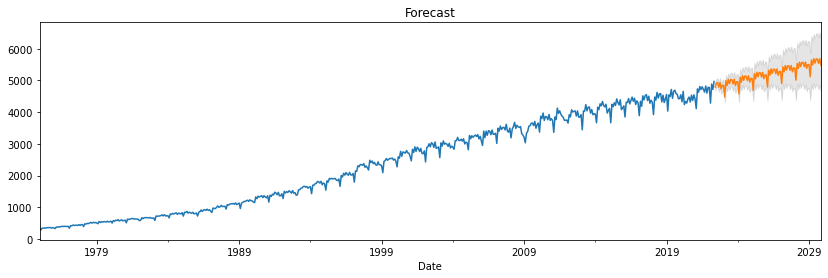

In [104]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=90)

## confidence intervals
fore_ci = forecast.conf_int()
ax = df['Electricity Generation'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("Forecast")
plt.show()

In [19]:
## define params
orders = [(1,0,1),(1,0,2),(1,0,3),(1,0,4),(1,0,5),(1,0,6),(1,0,7),
          (1,1,1),(1,1,2),(1,1,3),(1,1,4),(1,1,5),(1,1,6),(1,1,7),
          (2,0,1),(2,0,2),(2,0,3),(2,0,4),(2,0,5),(2,0,6),(2,0,7),
          (2,1,1),(2,1,2),(2,1,3),(2,1,4),(2,1,5),(2,1,6),(2,1,7),
          (3,0,1),(3,0,2),(3,0,3),(3,0,4),(3,0,5),(3,0,6),(3,0,6),
          (3,1,1),(3,1,2),(3,1,3),(3,1,4),(3,1,5),(3,1,6),(3,1,7),
          (4,0,1),(4,0,2),(4,0,3),(4,0,4),(4,0,5),(4,0,6),(4,0,7),
          (4,1,1),(4,1,2),(4,1,3),(4,1,4),(4,1,5),(4,1,6),(4,1,7),
          (5,0,1),(5,0,2),(5,0,3),(5,0,4),(5,0,5),(5,0,6),(5,0,7),
          (5,1,1),(5,1,2),(5,1,3),(5,1,4),(5,1,5),(5,1,6),(5,1,7),
          (6,0,1),(6,0,2),(6,0,3),(6,0,4),(6,0,5),(6,0,6),(6,0,7),
          (6,1,1),(6,1,2),(6,1,3),(6,1,4),(6,1,5),(6,1,6),(6,1,7),
          (7,0,1),(7,0,2),(7,0,3),(7,0,4),(7,0,5),(7,0,6),(7,0,7),
          (7,1,1),(7,1,2),(7,1,3),(7,1,4),(7,1,5),(7,1,6),(7,1,7)
          ]

seasonal_orders = [(1,0,1,12),(1,0,2,12),(1,0,3,12),(1,0,4,12),(1,0,5,12),(1,0,6,12),(1,0,7,12),
          (1,1,1,12),(1,1,2,12),(1,1,3,12),(1,1,4,12),(1,1,5,12),(1,1,6,12),(1,1,7,12),
          (2,0,1,12),(2,0,2,12),(2,0,3,12),(2,0,4,12),(2,0,5,12),(2,0,6,12),(2,0,7,12),
          (2,1,1,12),(2,1,2,12),(2,1,3,12),(2,1,4,12),(2,1,5,12),(2,1,6,12),(2,1,7,1),
          (3,0,1,12),(3,0,2,12),(3,0,3,12),(3,0,4,12),(3,0,5,12),(3,0,6,12),(3,0,6,12),
          (3,1,1,12),(3,1,2,12),(3,1,3,12),(3,1,4,12),(3,1,5,12),(3,1,6,12),(3,1,7,12),
          (4,0,1,12),(4,0,2,12),(4,0,3,12),(4,0,4,12),(4,0,5,12),(4,0,6,12),(4,0,7,12),
          (4,1,1,12),(4,1,2,12),(4,1,3,12),(4,1,4,12),(4,1,5,12),(4,1,6,12),(4,1,7,12),
          (5,0,1,12),(5,0,2,12),(5,0,3,12),(5,0,4,12),(5,0,5,12),(5,0,6,12),(5,0,7,12),
          (5,1,1,12),(5,1,2,12),(5,1,3,12),(5,1,4,12),(5,1,5,12),(5,1,6,12),(5,1,7,12),
          (6,0,1,12),(6,0,2,12),(6,0,3,12),(6,0,4,12),(6,0,5,12),(6,0,6,12),(6,0,7,12),
          (6,1,1,12),(6,1,2,12),(6,1,3,12),(6,1,4,12),(6,1,5,12),(6,1,6,12),(6,1,7,12),
          (7,0,1,12),(7,0,2,12),(7,0,3,12),(7,0,4,12),(7,0,5,12),(7,0,6,12),(7,0,7,12),
          (7,1,1,12),(7,1,2,12),(7,1,3,12),(7,1,4,12),(7,1,5,12),(7,1,6,12),(7,1,7,12)
          ]

In [ ]:
prediction_df = pd.DataFrame()
metrics_df = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])

for order in orders:
    for seasonal_order in seasonal_orders:
        print("trying "+str(order),str(seasonal_order))
        try:
            arima_model = SARIMAX(train_data['Electricity Generation'], order=order,
                          seasonal_order=seasonal_order,
                          trend='n').fit()
        
            pred = arima_model.get_prediction(start='1975-02', end='2022-05').predicted_mean
            prediction_df[f'{order},{seasonal_order}'] = pred

            rmse_train = round(mean_squared_error(train_data['Electricity Generation'], pred[pred.index<='1998-09'], squared=False), 2)
            rmse_test = round(mean_squared_error(test_data['Electricity Generation'], pred[pred.index>'1998-09'], squared=False), 2)
            metrics_df = metrics_df.append({'model': f'{order},{seasonal_order}', 'RMSE_train': rmse_train, 'RMSE_test': rmse_test, 'AIC': arima_model.aic}, ignore_index=True)
        except:
            print("")

trying (1, 0, 1) (1, 0, 1, 12)
trying (1, 0, 1) (1, 0, 2, 12)
trying (1, 0, 1) (1, 0, 3, 12)
trying (1, 0, 1) (1, 0, 4, 12)
trying (1, 0, 1) (1, 0, 5, 12)
trying (1, 0, 1) (1, 0, 6, 12)
trying (1, 0, 1) (1, 0, 7, 12)
trying (1, 0, 1) (1, 1, 1, 12)
trying (1, 0, 1) (1, 1, 2, 12)
trying (1, 0, 1) (1, 1, 3, 12)
trying (1, 0, 1) (1, 1, 4, 12)
trying (1, 0, 1) (1, 1, 5, 12)
trying (1, 0, 1) (1, 1, 6, 12)
trying (1, 0, 1) (1, 1, 7, 12)
trying (1, 0, 1) (2, 0, 1, 12)
trying (1, 0, 1) (2, 0, 2, 12)
trying (1, 0, 1) (2, 0, 3, 12)
trying (1, 0, 1) (2, 0, 4, 12)
trying (1, 0, 1) (2, 0, 5, 12)

trying (1, 0, 1) (2, 0, 6, 12)
trying (1, 0, 1) (2, 0, 7, 12)
trying (1, 0, 1) (2, 1, 1, 12)
trying (1, 0, 1) (2, 1, 2, 12)
trying (1, 0, 1) (2, 1, 3, 12)
trying (1, 0, 1) (2, 1, 4, 12)
trying (1, 0, 1) (2, 1, 5, 12)
trying (1, 0, 1) (2, 1, 6, 12)
trying (1, 0, 1) (2, 1, 7, 1)

trying (1, 0, 1) (3, 0, 1, 12)
trying (1, 0, 1) (3, 0, 2, 12)
trying (1, 0, 1) (3, 0, 3, 12)

trying (1, 0, 1) (3, 0, 4, 12)
trying

trying (1, 0, 3) (5, 1, 6, 12)
trying (1, 0, 3) (5, 1, 7, 12)
trying (1, 0, 3) (6, 0, 1, 12)
trying (1, 0, 3) (6, 0, 2, 12)
trying (1, 0, 3) (6, 0, 3, 12)
trying (1, 0, 3) (6, 0, 4, 12)
trying (1, 0, 3) (6, 0, 5, 12)
trying (1, 0, 3) (6, 0, 6, 12)
trying (1, 0, 3) (6, 0, 7, 12)
trying (1, 0, 3) (6, 1, 1, 12)
trying (1, 0, 3) (6, 1, 2, 12)
trying (1, 0, 3) (6, 1, 3, 12)
trying (1, 0, 3) (6, 1, 4, 12)
trying (1, 0, 3) (6, 1, 5, 12)
trying (1, 0, 3) (6, 1, 6, 12)
trying (1, 0, 3) (6, 1, 7, 12)
trying (1, 0, 3) (7, 0, 1, 12)
trying (1, 0, 3) (7, 0, 2, 12)
trying (1, 0, 3) (7, 0, 3, 12)
trying (1, 0, 3) (7, 0, 4, 12)
trying (1, 0, 3) (7, 0, 5, 12)
trying (1, 0, 3) (7, 0, 6, 12)

trying (1, 0, 3) (7, 0, 7, 12)

trying (1, 0, 3) (7, 1, 1, 12)
trying (1, 0, 3) (7, 1, 2, 12)
trying (1, 0, 3) (7, 1, 3, 12)
trying (1, 0, 3) (7, 1, 4, 12)
trying (1, 0, 3) (7, 1, 5, 12)
trying (1, 0, 3) (7, 1, 6, 12)
trying (1, 0, 3) (7, 1, 7, 12)

trying (1, 0, 4) (1, 0, 1, 12)
trying (1, 0, 4) (1, 0, 2, 12)
tryin

trying (1, 0, 6) (3, 1, 4, 12)
trying (1, 0, 6) (3, 1, 5, 12)
trying (1, 0, 6) (3, 1, 6, 12)
trying (1, 0, 6) (3, 1, 7, 12)
trying (1, 0, 6) (4, 0, 1, 12)
trying (1, 0, 6) (4, 0, 2, 12)
trying (1, 0, 6) (4, 0, 3, 12)
trying (1, 0, 6) (4, 0, 4, 12)

trying (1, 0, 6) (4, 0, 5, 12)
trying (1, 0, 6) (4, 0, 6, 12)
trying (1, 0, 6) (4, 0, 7, 12)
trying (1, 0, 6) (4, 1, 1, 12)
trying (1, 0, 6) (4, 1, 2, 12)
trying (1, 0, 6) (4, 1, 3, 12)
trying (1, 0, 6) (4, 1, 4, 12)
trying (1, 0, 6) (4, 1, 5, 12)
trying (1, 0, 6) (4, 1, 6, 12)
trying (1, 0, 6) (4, 1, 7, 12)
trying (1, 0, 6) (5, 0, 1, 12)
trying (1, 0, 6) (5, 0, 2, 12)
trying (1, 0, 6) (5, 0, 3, 12)
trying (1, 0, 6) (5, 0, 4, 12)
trying (1, 0, 6) (5, 0, 5, 12)

trying (1, 0, 6) (5, 0, 6, 12)
trying (1, 0, 6) (5, 0, 7, 12)

trying (1, 0, 6) (5, 1, 1, 12)
trying (1, 0, 6) (5, 1, 2, 12)
trying (1, 0, 6) (5, 1, 3, 12)


In [ ]:
metrics_df_rmse = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
metrics_df_aic = pd.DataFrame(columns=['model', 'RMSE_train', 'RMSE_test', 'AIC'])
metrics_df_rmse = metrics_df.sort_values('RMSE_test')
metrics_df_aic = metrics_df.sort_values('AIC')